In [1]:
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from pathlib import Path
from sklearn.metrics import ConfusionMatrixDisplay

from python import classes, metrics, data_loader

In [2]:
notebook_classification = ""
notebook_cv = 0

image_size = 112
batch_size = 128
max_epochs = 300
lr_scheduler_patience = 10
early_stopping_patience = 15
total_cv = 5

data_dir = "data"
tensorboard_dir = "out/logs"
metrics_dir = "out/metrics"
models_dir = "out/keras"
weights_dir = "out/weights"

In [3]:
# Parameters
notebook_classification = "models"
notebook_cv = 4


In [4]:
assert notebook_classification in ['models', 'types'], "notebook_classification must be one of ['models', 'types']"
assert notebook_cv != 0, "notebook_cv must be provided"
assert 1 <= notebook_cv <= total_cv, "notebook_cv must be in the range [1, total_cv]"

In [5]:
class_names = classes.class_names[notebook_classification]
classes_num = len(class_names)

notebook_model = "m2"
data_dir = Path(data_dir) / f"{notebook_classification}"
tensorboard_dir = Path(tensorboard_dir) / f"{notebook_model}/{notebook_classification}/cv{notebook_cv}"
metrics_file = Path(metrics_dir) / f"{notebook_model}/{notebook_classification}.json"
model_file = Path(models_dir) / f"{notebook_model}/{notebook_classification}/cv{notebook_cv}.keras"
weights_file = Path(weights_dir) / f"{notebook_model}/{notebook_classification}/cv{notebook_cv}.weights.h5"

In [6]:
assert not model_file.is_file(), "This model already exists"

In [7]:
shutil.rmtree(tensorboard_dir, ignore_errors=True)

tensorboard_dir.mkdir(parents=True, exist_ok=True)
metrics_file.parent.mkdir(parents=True, exist_ok=True)
model_file.parent.mkdir(parents=True, exist_ok=True)
weights_file.parent.mkdir(parents=True, exist_ok=True)

In [8]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [9]:
train_data, val_data = data_loader.load_data(
    data_dir=data_dir,
    val_fold=notebook_cv,
    total_folds=total_cv,
    class_names=class_names,
    batch_size=batch_size,
    image_size=image_size
)

Found 6383 files belonging to 74 classes.


Found 6384 files belonging to 74 classes.
Found 6384 files belonging to 74 classes.


Found 6383 files belonging to 74 classes.
Found 6383 files belonging to 74 classes.


In [10]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1)
])

In [11]:
model = models.Sequential()

# Input layer
model.add(layers.Input(shape=(image_size, image_size, 3)))
model.add(data_augmentation)
model.add(layers.Rescaling(1./255))

# First block
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# Second block
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# Third block
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# Fourth block
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# Fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))

# Output layer
model.add(layers.Dense(classes_num, activation='softmax'))

model.summary()

Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 sequential (Sequential)     (None, 112, 112, 3)       0         


 rescaling (Rescaling)       (None, 112, 112, 3)       0         


 conv2d (Conv2D)             (None, 112, 112, 32)      896       


 batch_normalization (BatchN  (None, 112, 112, 32)     128       


 ormalization)                                                   


 dropout (Dropout)           (None, 112, 112, 32)      0         


 conv2d_1 (Conv2D)           (None, 112, 112, 32)      9248      


 batch_normalization_1 (Batc  (None, 112, 112, 32)     128       


 hNormalization)                                                 


 max_pooling2d (MaxPooling2D  (None, 56, 56, 32)       0         


 )                                                               


 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     


 batch_normalization_2 (Batc  (None, 56, 56, 64)       256       


 hNormalization)                                                 


 dropout_1 (Dropout)         (None, 56, 56, 64)        0         


 conv2d_3 (Conv2D)           (None, 56, 56, 64)        36928     


 batch_normalization_3 (Batc  (None, 56, 56, 64)       256       


 hNormalization)                                                 


 max_pooling2d_1 (MaxPooling  (None, 28, 28, 64)       0         


 2D)                                                             


 conv2d_4 (Conv2D)           (None, 28, 28, 128)       73856     


 batch_normalization_4 (Batc  (None, 28, 28, 128)      512       


 hNormalization)                                                 


 dropout_2 (Dropout)         (None, 28, 28, 128)       0         


 conv2d_5 (Conv2D)           (None, 28, 28, 128)       147584    


 batch_normalization_5 (Batc  (None, 28, 28, 128)      512       


 hNormalization)                                                 


 conv2d_6 (Conv2D)           (None, 28, 28, 128)       147584    


 batch_normalization_6 (Batc  (None, 28, 28, 128)      512       


 hNormalization)                                                 


 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0         


 2D)                                                             


 conv2d_7 (Conv2D)           (None, 14, 14, 256)       295168    


 batch_normalization_7 (Batc  (None, 14, 14, 256)      1024      


 hNormalization)                                                 


 dropout_3 (Dropout)         (None, 14, 14, 256)       0         


 conv2d_8 (Conv2D)           (None, 14, 14, 256)       590080    


 batch_normalization_8 (Batc  (None, 14, 14, 256)      1024      


 hNormalization)                                                 


 conv2d_9 (Conv2D)           (None, 14, 14, 256)       590080    


 batch_normalization_9 (Batc  (None, 14, 14, 256)      1024      


 hNormalization)                                                 


 max_pooling2d_3 (MaxPooling  (None, 7, 7, 256)        0         


 2D)                                                             


 flatten (Flatten)           (None, 12544)             0         


 dense (Dense)               (None, 256)               3211520   


 dropout_4 (Dropout)         (None, 256)               0         


 dense_1 (Dense)             (None, 512)               131584    


 dropout_5 (Dropout)         (None, 512)               0         


 dense_2 (Dense)             (None, 74)                37962     


Total params: 5,296,362


Trainable params: 5,293,674


Non-trainable params: 2,688


_________________________________________________________________


In [12]:
model.compile(
    optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[
        'accuracy', 
        metrics.F1Macro(classes_num), 
        metrics.PrecisionMacro(classes_num),
        metrics.RecallMacro(classes_num)
    ]
)

In [13]:
tensorboard = TensorBoard(log_dir=tensorboard_dir)
checkpoint = ModelCheckpoint(weights_file, save_best_only=True, save_weights_only=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=lr_scheduler_patience, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience)

model.fit(
    train_data, epochs=max_epochs, validation_data=val_data, verbose=2,
    callbacks=[
        tensorboard, checkpoint, lr_scheduler, early_stopping
    ]
);

Epoch 1/300


200/200 - 63s - loss: 4.2081 - accuracy: 0.0517 - f1: 0.0114 - precision: 0.0184 - recall: 0.0173 - val_loss: 4.0747 - val_accuracy: 0.0498 - val_f1: 0.0025 - val_precision: 0.0015 - val_recall: 0.0136 - lr: 0.0010 - 63s/epoch - 315ms/step


Epoch 2/300


200/200 - 53s - loss: 4.0142 - accuracy: 0.0608 - f1: 0.0135 - precision: 0.0169 - recall: 0.0223 - val_loss: 4.0370 - val_accuracy: 0.0550 - val_f1: 0.0044 - val_precision: 0.0044 - val_recall: 0.0149 - lr: 0.0010 - 53s/epoch - 264ms/step


Epoch 3/300


200/200 - 52s - loss: 3.9441 - accuracy: 0.0710 - f1: 0.0193 - precision: 0.0306 - recall: 0.0282 - val_loss: 4.0258 - val_accuracy: 0.0559 - val_f1: 0.0050 - val_precision: 0.0043 - val_recall: 0.0154 - lr: 0.0010 - 52s/epoch - 262ms/step


Epoch 4/300


200/200 - 53s - loss: 3.8961 - accuracy: 0.0758 - f1: 0.0254 - precision: 0.0382 - recall: 0.0336 - val_loss: 3.9004 - val_accuracy: 0.0808 - val_f1: 0.0191 - val_precision: 0.0446 - val_recall: 0.0286 - lr: 0.0010 - 53s/epoch - 265ms/step


Epoch 5/300


200/200 - 53s - loss: 3.8532 - accuracy: 0.0815 - f1: 0.0315 - precision: 0.0446 - recall: 0.0396 - val_loss: 3.8075 - val_accuracy: 0.0957 - val_f1: 0.0339 - val_precision: 0.0511 - val_recall: 0.0416 - lr: 0.0010 - 53s/epoch - 266ms/step


Epoch 6/300


200/200 - 53s - loss: 3.8121 - accuracy: 0.0905 - f1: 0.0371 - precision: 0.0606 - recall: 0.0448 - val_loss: 3.7511 - val_accuracy: 0.0973 - val_f1: 0.0409 - val_precision: 0.0663 - val_recall: 0.0486 - lr: 0.0010 - 53s/epoch - 263ms/step


Epoch 7/300


200/200 - 52s - loss: 3.7917 - accuracy: 0.0923 - f1: 0.0403 - precision: 0.0595 - recall: 0.0470 - val_loss: 3.7996 - val_accuracy: 0.0937 - val_f1: 0.0385 - val_precision: 0.1013 - val_recall: 0.0417 - lr: 0.0010 - 52s/epoch - 261ms/step


Epoch 8/300


200/200 - 53s - loss: 3.7602 - accuracy: 0.0970 - f1: 0.0470 - precision: 0.0804 - recall: 0.0521 - val_loss: 3.8033 - val_accuracy: 0.0935 - val_f1: 0.0388 - val_precision: 0.0812 - val_recall: 0.0471 - lr: 0.0010 - 53s/epoch - 263ms/step


Epoch 9/300


200/200 - 53s - loss: 3.7379 - accuracy: 0.1022 - f1: 0.0530 - precision: 0.0878 - recall: 0.0562 - val_loss: 3.6553 - val_accuracy: 0.1184 - val_f1: 0.0681 - val_precision: 0.1191 - val_recall: 0.0696 - lr: 0.0010 - 53s/epoch - 263ms/step


Epoch 10/300


200/200 - 52s - loss: 3.7078 - accuracy: 0.1098 - f1: 0.0594 - precision: 0.0995 - recall: 0.0616 - val_loss: 3.7044 - val_accuracy: 0.1139 - val_f1: 0.0590 - val_precision: 0.1029 - val_recall: 0.0668 - lr: 0.0010 - 52s/epoch - 260ms/step


Epoch 11/300


200/200 - 53s - loss: 3.6761 - accuracy: 0.1163 - f1: 0.0665 - precision: 0.1143 - recall: 0.0670 - val_loss: 3.6421 - val_accuracy: 0.1203 - val_f1: 0.0647 - val_precision: 0.1364 - val_recall: 0.0636 - lr: 0.0010 - 53s/epoch - 267ms/step


Epoch 12/300


200/200 - 53s - loss: 3.6384 - accuracy: 0.1197 - f1: 0.0714 - precision: 0.1131 - recall: 0.0710 - val_loss: 3.6191 - val_accuracy: 0.1256 - val_f1: 0.0659 - val_precision: 0.1766 - val_recall: 0.0642 - lr: 0.0010 - 53s/epoch - 266ms/step


Epoch 13/300


200/200 - 53s - loss: 3.6114 - accuracy: 0.1273 - f1: 0.0778 - precision: 0.1225 - recall: 0.0766 - val_loss: 3.5165 - val_accuracy: 0.1438 - val_f1: 0.0932 - val_precision: 0.1539 - val_recall: 0.0900 - lr: 0.0010 - 53s/epoch - 266ms/step


Epoch 14/300


200/200 - 54s - loss: 3.5628 - accuracy: 0.1364 - f1: 0.0885 - precision: 0.1410 - recall: 0.0855 - val_loss: 3.8859 - val_accuracy: 0.0863 - val_f1: 0.0339 - val_precision: 0.0744 - val_recall: 0.0472 - lr: 0.0010 - 54s/epoch - 268ms/step


Epoch 15/300


200/200 - 54s - loss: 3.5390 - accuracy: 0.1418 - f1: 0.0966 - precision: 0.1522 - recall: 0.0923 - val_loss: 3.5283 - val_accuracy: 0.1386 - val_f1: 0.0857 - val_precision: 0.1543 - val_recall: 0.0873 - lr: 0.0010 - 54s/epoch - 270ms/step


Epoch 16/300


200/200 - 56s - loss: 3.4843 - accuracy: 0.1483 - f1: 0.1034 - precision: 0.1492 - recall: 0.0986 - val_loss: 3.3537 - val_accuracy: 0.1741 - val_f1: 0.1228 - val_precision: 0.2202 - val_recall: 0.1150 - lr: 0.0010 - 56s/epoch - 278ms/step


Epoch 17/300


200/200 - 56s - loss: 3.4266 - accuracy: 0.1602 - f1: 0.1163 - precision: 0.1789 - recall: 0.1096 - val_loss: 3.3716 - val_accuracy: 0.1692 - val_f1: 0.1209 - val_precision: 0.1807 - val_recall: 0.1217 - lr: 0.0010 - 56s/epoch - 279ms/step


Epoch 18/300


200/200 - 54s - loss: 3.3737 - accuracy: 0.1703 - f1: 0.1276 - precision: 0.1875 - recall: 0.1198 - val_loss: 3.3919 - val_accuracy: 0.1672 - val_f1: 0.1091 - val_precision: 0.2356 - val_recall: 0.1041 - lr: 0.0010 - 54s/epoch - 271ms/step


Epoch 19/300


200/200 - 54s - loss: 3.3286 - accuracy: 0.1767 - f1: 0.1329 - precision: 0.1852 - recall: 0.1248 - val_loss: 3.3107 - val_accuracy: 0.1825 - val_f1: 0.1417 - val_precision: 0.2173 - val_recall: 0.1404 - lr: 0.0010 - 54s/epoch - 271ms/step


Epoch 20/300


200/200 - 54s - loss: 3.2784 - accuracy: 0.1874 - f1: 0.1458 - precision: 0.2048 - recall: 0.1355 - val_loss: 3.2335 - val_accuracy: 0.1991 - val_f1: 0.1538 - val_precision: 0.2293 - val_recall: 0.1451 - lr: 0.0010 - 54s/epoch - 268ms/step


Epoch 21/300


200/200 - 54s - loss: 3.2249 - accuracy: 0.1979 - f1: 0.1554 - precision: 0.2128 - recall: 0.1454 - val_loss: 3.1105 - val_accuracy: 0.2258 - val_f1: 0.1685 - val_precision: 0.3032 - val_recall: 0.1625 - lr: 0.0010 - 54s/epoch - 269ms/step


Epoch 22/300


200/200 - 54s - loss: 3.1641 - accuracy: 0.2076 - f1: 0.1674 - precision: 0.2278 - recall: 0.1553 - val_loss: 3.1709 - val_accuracy: 0.2096 - val_f1: 0.1511 - val_precision: 0.2988 - val_recall: 0.1355 - lr: 0.0010 - 54s/epoch - 268ms/step


Epoch 23/300


200/200 - 54s - loss: 3.0972 - accuracy: 0.2197 - f1: 0.1798 - precision: 0.2437 - recall: 0.1671 - val_loss: 2.9264 - val_accuracy: 0.2612 - val_f1: 0.2062 - val_precision: 0.2986 - val_recall: 0.1995 - lr: 0.0010 - 54s/epoch - 270ms/step


Epoch 24/300


200/200 - 54s - loss: 3.0334 - accuracy: 0.2324 - f1: 0.1913 - precision: 0.2607 - recall: 0.1787 - val_loss: 2.8530 - val_accuracy: 0.2773 - val_f1: 0.2296 - val_precision: 0.3104 - val_recall: 0.2225 - lr: 0.0010 - 54s/epoch - 268ms/step


Epoch 25/300


200/200 - 54s - loss: 2.9666 - accuracy: 0.2477 - f1: 0.2105 - precision: 0.2785 - recall: 0.1957 - val_loss: 2.8498 - val_accuracy: 0.2812 - val_f1: 0.2422 - val_precision: 0.3087 - val_recall: 0.2359 - lr: 0.0010 - 54s/epoch - 268ms/step


Epoch 26/300


200/200 - 53s - loss: 2.9070 - accuracy: 0.2597 - f1: 0.2210 - precision: 0.2802 - recall: 0.2067 - val_loss: 2.9660 - val_accuracy: 0.2615 - val_f1: 0.1997 - val_precision: 0.2904 - val_recall: 0.1926 - lr: 0.0010 - 53s/epoch - 266ms/step


Epoch 27/300


200/200 - 53s - loss: 2.8476 - accuracy: 0.2702 - f1: 0.2325 - precision: 0.2944 - recall: 0.2169 - val_loss: 2.7417 - val_accuracy: 0.3099 - val_f1: 0.2669 - val_precision: 0.3796 - val_recall: 0.2453 - lr: 0.0010 - 53s/epoch - 264ms/step


Epoch 28/300


200/200 - 54s - loss: 2.7951 - accuracy: 0.2824 - f1: 0.2475 - precision: 0.3109 - recall: 0.2315 - val_loss: 2.6586 - val_accuracy: 0.3252 - val_f1: 0.2747 - val_precision: 0.3709 - val_recall: 0.2676 - lr: 0.0010 - 54s/epoch - 270ms/step


Epoch 29/300


200/200 - 55s - loss: 2.7415 - accuracy: 0.2953 - f1: 0.2613 - precision: 0.3331 - recall: 0.2445 - val_loss: 2.6112 - val_accuracy: 0.3389 - val_f1: 0.2948 - val_precision: 0.3787 - val_recall: 0.2712 - lr: 0.0010 - 55s/epoch - 273ms/step


Epoch 30/300


200/200 - 54s - loss: 2.6638 - accuracy: 0.3116 - f1: 0.2752 - precision: 0.3486 - recall: 0.2583 - val_loss: 2.4987 - val_accuracy: 0.3597 - val_f1: 0.3116 - val_precision: 0.3639 - val_recall: 0.3066 - lr: 0.0010 - 54s/epoch - 270ms/step


Epoch 31/300


200/200 - 53s - loss: 2.6140 - accuracy: 0.3229 - f1: 0.2869 - precision: 0.3507 - recall: 0.2698 - val_loss: 2.4776 - val_accuracy: 0.3628 - val_f1: 0.3308 - val_precision: 0.4076 - val_recall: 0.3088 - lr: 0.0010 - 53s/epoch - 267ms/step


Epoch 32/300


200/200 - 53s - loss: 2.5337 - accuracy: 0.3364 - f1: 0.2984 - precision: 0.3523 - recall: 0.2821 - val_loss: 2.4361 - val_accuracy: 0.3729 - val_f1: 0.3270 - val_precision: 0.3957 - val_recall: 0.3188 - lr: 0.0010 - 53s/epoch - 266ms/step


Epoch 33/300


200/200 - 53s - loss: 2.4933 - accuracy: 0.3514 - f1: 0.3152 - precision: 0.3699 - recall: 0.2984 - val_loss: 2.5017 - val_accuracy: 0.3807 - val_f1: 0.3397 - val_precision: 0.4032 - val_recall: 0.3284 - lr: 0.0010 - 53s/epoch - 266ms/step


Epoch 34/300


200/200 - 53s - loss: 2.4278 - accuracy: 0.3612 - f1: 0.3253 - precision: 0.3771 - recall: 0.3076 - val_loss: 2.2674 - val_accuracy: 0.4156 - val_f1: 0.3726 - val_precision: 0.4679 - val_recall: 0.3512 - lr: 0.0010 - 53s/epoch - 265ms/step


Epoch 35/300


200/200 - 53s - loss: 2.3891 - accuracy: 0.3738 - f1: 0.3400 - precision: 0.3917 - recall: 0.3220 - val_loss: 2.2480 - val_accuracy: 0.4172 - val_f1: 0.3794 - val_precision: 0.4445 - val_recall: 0.3673 - lr: 0.0010 - 53s/epoch - 265ms/step


Epoch 36/300


200/200 - 53s - loss: 2.3349 - accuracy: 0.3841 - f1: 0.3491 - precision: 0.3971 - recall: 0.3304 - val_loss: 2.4524 - val_accuracy: 0.3749 - val_f1: 0.3218 - val_precision: 0.4155 - val_recall: 0.3110 - lr: 0.0010 - 53s/epoch - 265ms/step


Epoch 37/300


200/200 - 53s - loss: 2.2781 - accuracy: 0.3947 - f1: 0.3654 - precision: 0.4132 - recall: 0.3468 - val_loss: 2.1298 - val_accuracy: 0.4412 - val_f1: 0.4015 - val_precision: 0.4713 - val_recall: 0.3804 - lr: 0.0010 - 53s/epoch - 267ms/step


Epoch 38/300


200/200 - 54s - loss: 2.2407 - accuracy: 0.4120 - f1: 0.3791 - precision: 0.4240 - recall: 0.3619 - val_loss: 2.1497 - val_accuracy: 0.4462 - val_f1: 0.4059 - val_precision: 0.4876 - val_recall: 0.3872 - lr: 0.0010 - 54s/epoch - 270ms/step


Epoch 39/300


200/200 - 54s - loss: 2.2157 - accuracy: 0.4098 - f1: 0.3834 - precision: 0.4334 - recall: 0.3637 - val_loss: 2.3774 - val_accuracy: 0.3962 - val_f1: 0.3643 - val_precision: 0.4315 - val_recall: 0.3583 - lr: 0.0010 - 54s/epoch - 270ms/step


Epoch 40/300


200/200 - 53s - loss: 2.2519 - accuracy: 0.4086 - f1: 0.3794 - precision: 0.4233 - recall: 0.3597 - val_loss: 2.2130 - val_accuracy: 0.4318 - val_f1: 0.3837 - val_precision: 0.4586 - val_recall: 0.3747 - lr: 0.0010 - 53s/epoch - 265ms/step


Epoch 41/300


200/200 - 53s - loss: 2.1536 - accuracy: 0.4261 - f1: 0.3977 - precision: 0.4471 - recall: 0.3778 - val_loss: 2.0450 - val_accuracy: 0.4767 - val_f1: 0.4350 - val_precision: 0.4822 - val_recall: 0.4254 - lr: 0.0010 - 53s/epoch - 266ms/step


Epoch 42/300


200/200 - 53s - loss: 2.0940 - accuracy: 0.4427 - f1: 0.4116 - precision: 0.4507 - recall: 0.3954 - val_loss: 2.0114 - val_accuracy: 0.4745 - val_f1: 0.4306 - val_precision: 0.4903 - val_recall: 0.4136 - lr: 0.0010 - 53s/epoch - 264ms/step


Epoch 43/300


200/200 - 52s - loss: 2.0496 - accuracy: 0.4567 - f1: 0.4255 - precision: 0.4624 - recall: 0.4075 - val_loss: 1.9132 - val_accuracy: 0.4966 - val_f1: 0.4490 - val_precision: 0.4926 - val_recall: 0.4382 - lr: 0.0010 - 52s/epoch - 261ms/step


Epoch 44/300


200/200 - 54s - loss: 2.0099 - accuracy: 0.4598 - f1: 0.4346 - precision: 0.4724 - recall: 0.4154 - val_loss: 1.9594 - val_accuracy: 0.4921 - val_f1: 0.4556 - val_precision: 0.5265 - val_recall: 0.4412 - lr: 0.0010 - 54s/epoch - 270ms/step


Epoch 45/300


200/200 - 54s - loss: 1.9538 - accuracy: 0.4723 - f1: 0.4462 - precision: 0.4834 - recall: 0.4279 - val_loss: 1.8531 - val_accuracy: 0.5200 - val_f1: 0.4823 - val_precision: 0.5229 - val_recall: 0.4717 - lr: 0.0010 - 54s/epoch - 271ms/step


Epoch 46/300


200/200 - 53s - loss: 1.9144 - accuracy: 0.4817 - f1: 0.4545 - precision: 0.4902 - recall: 0.4359 - val_loss: 1.8505 - val_accuracy: 0.5128 - val_f1: 0.4712 - val_precision: 0.5086 - val_recall: 0.4639 - lr: 0.0010 - 53s/epoch - 266ms/step


Epoch 47/300


200/200 - 52s - loss: 1.8762 - accuracy: 0.4896 - f1: 0.4659 - precision: 0.5028 - recall: 0.4475 - val_loss: 1.8973 - val_accuracy: 0.5078 - val_f1: 0.4776 - val_precision: 0.5147 - val_recall: 0.4683 - lr: 0.0010 - 52s/epoch - 258ms/step


Epoch 48/300


200/200 - 52s - loss: 1.8581 - accuracy: 0.4961 - f1: 0.4685 - precision: 0.5045 - recall: 0.4494 - val_loss: 1.8678 - val_accuracy: 0.5139 - val_f1: 0.4740 - val_precision: 0.5182 - val_recall: 0.4672 - lr: 0.0010 - 52s/epoch - 261ms/step


Epoch 49/300


200/200 - 53s - loss: 1.8384 - accuracy: 0.4985 - f1: 0.4764 - precision: 0.5186 - recall: 0.4564 - val_loss: 1.9263 - val_accuracy: 0.5038 - val_f1: 0.4734 - val_precision: 0.5331 - val_recall: 0.4540 - lr: 0.0010 - 53s/epoch - 263ms/step


Epoch 50/300


200/200 - 53s - loss: 1.7817 - accuracy: 0.5141 - f1: 0.4951 - precision: 0.5293 - recall: 0.4772 - val_loss: 1.7808 - val_accuracy: 0.5372 - val_f1: 0.5082 - val_precision: 0.5713 - val_recall: 0.4853 - lr: 0.0010 - 53s/epoch - 263ms/step


Epoch 51/300


200/200 - 53s - loss: 1.7637 - accuracy: 0.5184 - f1: 0.4951 - precision: 0.5283 - recall: 0.4766 - val_loss: 1.7456 - val_accuracy: 0.5425 - val_f1: 0.5101 - val_precision: 0.5516 - val_recall: 0.4974 - lr: 0.0010 - 53s/epoch - 264ms/step


Epoch 52/300


200/200 - 57s - loss: 1.7231 - accuracy: 0.5256 - f1: 0.5049 - precision: 0.5334 - recall: 0.4880 - val_loss: 1.7348 - val_accuracy: 0.5501 - val_f1: 0.5151 - val_precision: 0.5462 - val_recall: 0.5060 - lr: 0.0010 - 57s/epoch - 284ms/step


Epoch 53/300


200/200 - 52s - loss: 1.7123 - accuracy: 0.5314 - f1: 0.5106 - precision: 0.5451 - recall: 0.4905 - val_loss: 1.8423 - val_accuracy: 0.5230 - val_f1: 0.4852 - val_precision: 0.5398 - val_recall: 0.4749 - lr: 0.0010 - 52s/epoch - 261ms/step


Epoch 54/300


200/200 - 52s - loss: 1.7160 - accuracy: 0.5352 - f1: 0.5117 - precision: 0.5420 - recall: 0.4956 - val_loss: 1.7178 - val_accuracy: 0.5548 - val_f1: 0.5199 - val_precision: 0.5514 - val_recall: 0.5102 - lr: 0.0010 - 52s/epoch - 260ms/step


Epoch 55/300


200/200 - 51s - loss: 1.6649 - accuracy: 0.5418 - f1: 0.5225 - precision: 0.5549 - recall: 0.5039 - val_loss: 1.6907 - val_accuracy: 0.5590 - val_f1: 0.5176 - val_precision: 0.5713 - val_recall: 0.5045 - lr: 0.0010 - 51s/epoch - 257ms/step


Epoch 56/300


200/200 - 51s - loss: 1.6463 - accuracy: 0.5541 - f1: 0.5321 - precision: 0.5628 - recall: 0.5142 - val_loss: 1.6596 - val_accuracy: 0.5685 - val_f1: 0.5285 - val_precision: 0.5693 - val_recall: 0.5161 - lr: 0.0010 - 51s/epoch - 256ms/step


Epoch 57/300


200/200 - 51s - loss: 1.6124 - accuracy: 0.5549 - f1: 0.5382 - precision: 0.5671 - recall: 0.5203 - val_loss: 1.6338 - val_accuracy: 0.5731 - val_f1: 0.5383 - val_precision: 0.5791 - val_recall: 0.5200 - lr: 0.0010 - 51s/epoch - 255ms/step


Epoch 58/300


200/200 - 52s - loss: 1.5821 - accuracy: 0.5605 - f1: 0.5395 - precision: 0.5687 - recall: 0.5225 - val_loss: 1.6626 - val_accuracy: 0.5673 - val_f1: 0.5248 - val_precision: 0.5508 - val_recall: 0.5156 - lr: 0.0010 - 52s/epoch - 260ms/step


Epoch 59/300


200/200 - 52s - loss: 1.5679 - accuracy: 0.5633 - f1: 0.5421 - precision: 0.5735 - recall: 0.5245 - val_loss: 1.6708 - val_accuracy: 0.5673 - val_f1: 0.5177 - val_precision: 0.5569 - val_recall: 0.5101 - lr: 0.0010 - 52s/epoch - 262ms/step


Epoch 60/300


200/200 - 51s - loss: 1.5472 - accuracy: 0.5705 - f1: 0.5488 - precision: 0.5765 - recall: 0.5322 - val_loss: 1.6645 - val_accuracy: 0.5739 - val_f1: 0.5463 - val_precision: 0.5810 - val_recall: 0.5327 - lr: 0.0010 - 51s/epoch - 255ms/step


Epoch 61/300


200/200 - 51s - loss: 1.5313 - accuracy: 0.5771 - f1: 0.5550 - precision: 0.5799 - recall: 0.5399 - val_loss: 1.6324 - val_accuracy: 0.5803 - val_f1: 0.5437 - val_precision: 0.5718 - val_recall: 0.5339 - lr: 0.0010 - 51s/epoch - 254ms/step


Epoch 62/300


200/200 - 51s - loss: 1.6255 - accuracy: 0.5591 - f1: 0.5418 - precision: 0.5696 - recall: 0.5247 - val_loss: 1.6762 - val_accuracy: 0.5665 - val_f1: 0.5235 - val_precision: 0.5625 - val_recall: 0.5165 - lr: 0.0010 - 51s/epoch - 257ms/step


Epoch 63/300


200/200 - 52s - loss: 1.5651 - accuracy: 0.5671 - f1: 0.5505 - precision: 0.5798 - recall: 0.5328 - val_loss: 1.6101 - val_accuracy: 0.5855 - val_f1: 0.5548 - val_precision: 0.5824 - val_recall: 0.5475 - lr: 0.0010 - 52s/epoch - 260ms/step


Epoch 64/300


200/200 - 52s - loss: 1.5302 - accuracy: 0.5797 - f1: 0.5637 - precision: 0.5915 - recall: 0.5459 - val_loss: 1.7810 - val_accuracy: 0.5458 - val_f1: 0.5092 - val_precision: 0.5606 - val_recall: 0.4955 - lr: 0.0010 - 52s/epoch - 258ms/step


Epoch 65/300


200/200 - 52s - loss: 1.4973 - accuracy: 0.5870 - f1: 0.5671 - precision: 0.5945 - recall: 0.5503 - val_loss: 1.6209 - val_accuracy: 0.5830 - val_f1: 0.5456 - val_precision: 0.5872 - val_recall: 0.5320 - lr: 0.0010 - 52s/epoch - 259ms/step


Epoch 66/300


200/200 - 51s - loss: 1.4576 - accuracy: 0.5945 - f1: 0.5767 - precision: 0.6002 - recall: 0.5609 - val_loss: 1.8078 - val_accuracy: 0.5469 - val_f1: 0.5257 - val_precision: 0.5725 - val_recall: 0.5167 - lr: 0.0010 - 51s/epoch - 256ms/step


Epoch 67/300


200/200 - 50s - loss: 1.4348 - accuracy: 0.6041 - f1: 0.5895 - precision: 0.6130 - recall: 0.5739 - val_loss: 1.6137 - val_accuracy: 0.5848 - val_f1: 0.5599 - val_precision: 0.5994 - val_recall: 0.5431 - lr: 0.0010 - 50s/epoch - 252ms/step


Epoch 68/300


200/200 - 50s - loss: 1.4498 - accuracy: 0.6065 - f1: 0.5905 - precision: 0.6189 - recall: 0.5726 - val_loss: 1.5834 - val_accuracy: 0.5967 - val_f1: 0.5643 - val_precision: 0.5990 - val_recall: 0.5567 - lr: 0.0010 - 50s/epoch - 252ms/step


Epoch 69/300


200/200 - 51s - loss: 1.4110 - accuracy: 0.6084 - f1: 0.5927 - precision: 0.6159 - recall: 0.5772 - val_loss: 1.5443 - val_accuracy: 0.6082 - val_f1: 0.5765 - val_precision: 0.6113 - val_recall: 0.5609 - lr: 0.0010 - 51s/epoch - 253ms/step


Epoch 70/300


200/200 - 51s - loss: 1.4080 - accuracy: 0.6105 - f1: 0.5946 - precision: 0.6189 - recall: 0.5786 - val_loss: 1.5439 - val_accuracy: 0.6054 - val_f1: 0.5654 - val_precision: 0.5800 - val_recall: 0.5667 - lr: 0.0010 - 51s/epoch - 257ms/step


Epoch 71/300


200/200 - 52s - loss: 1.3874 - accuracy: 0.6090 - f1: 0.5929 - precision: 0.6141 - recall: 0.5794 - val_loss: 1.9404 - val_accuracy: 0.5139 - val_f1: 0.4805 - val_precision: 0.5419 - val_recall: 0.4657 - lr: 0.0010 - 52s/epoch - 258ms/step


Epoch 72/300


200/200 - 52s - loss: 1.3588 - accuracy: 0.6171 - f1: 0.6032 - precision: 0.6291 - recall: 0.5864 - val_loss: 1.5661 - val_accuracy: 0.5913 - val_f1: 0.5493 - val_precision: 0.5722 - val_recall: 0.5448 - lr: 0.0010 - 52s/epoch - 260ms/step


Epoch 73/300


200/200 - 51s - loss: 1.3367 - accuracy: 0.6249 - f1: 0.6108 - precision: 0.6332 - recall: 0.5960 - val_loss: 1.5389 - val_accuracy: 0.6057 - val_f1: 0.5746 - val_precision: 0.5993 - val_recall: 0.5703 - lr: 0.0010 - 51s/epoch - 256ms/step


Epoch 74/300


200/200 - 51s - loss: 1.3291 - accuracy: 0.6288 - f1: 0.6159 - precision: 0.6381 - recall: 0.6007 - val_loss: 1.5665 - val_accuracy: 0.5960 - val_f1: 0.5586 - val_precision: 0.5972 - val_recall: 0.5433 - lr: 0.0010 - 51s/epoch - 256ms/step


Epoch 75/300


200/200 - 52s - loss: 1.3370 - accuracy: 0.6260 - f1: 0.6125 - precision: 0.6363 - recall: 0.5966 - val_loss: 1.8619 - val_accuracy: 0.5283 - val_f1: 0.4977 - val_precision: 0.5368 - val_recall: 0.4933 - lr: 0.0010 - 52s/epoch - 258ms/step


Epoch 76/300


200/200 - 52s - loss: 1.2970 - accuracy: 0.6379 - f1: 0.6228 - precision: 0.6430 - recall: 0.6085 - val_loss: 1.5121 - val_accuracy: 0.6133 - val_f1: 0.5793 - val_precision: 0.6004 - val_recall: 0.5759 - lr: 0.0010 - 52s/epoch - 259ms/step


Epoch 77/300


200/200 - 52s - loss: 1.2665 - accuracy: 0.6446 - f1: 0.6291 - precision: 0.6522 - recall: 0.6134 - val_loss: 1.5183 - val_accuracy: 0.6113 - val_f1: 0.5713 - val_precision: 0.6006 - val_recall: 0.5626 - lr: 0.0010 - 52s/epoch - 259ms/step


Epoch 78/300


200/200 - 52s - loss: 1.2783 - accuracy: 0.6429 - f1: 0.6297 - precision: 0.6545 - recall: 0.6127 - val_loss: 1.4954 - val_accuracy: 0.6213 - val_f1: 0.5884 - val_precision: 0.6171 - val_recall: 0.5755 - lr: 0.0010 - 52s/epoch - 259ms/step


Epoch 79/300


200/200 - 51s - loss: 1.2675 - accuracy: 0.6472 - f1: 0.6343 - precision: 0.6545 - recall: 0.6205 - val_loss: 1.8260 - val_accuracy: 0.5371 - val_f1: 0.5002 - val_precision: 0.5528 - val_recall: 0.4924 - lr: 0.0010 - 51s/epoch - 257ms/step


Epoch 80/300


200/200 - 51s - loss: 1.3319 - accuracy: 0.6271 - f1: 0.6123 - precision: 0.6339 - recall: 0.5964 - val_loss: 1.7491 - val_accuracy: 0.5626 - val_f1: 0.5345 - val_precision: 0.5704 - val_recall: 0.5251 - lr: 0.0010 - 51s/epoch - 254ms/step


Epoch 81/300


200/200 - 51s - loss: 1.3398 - accuracy: 0.6319 - f1: 0.6170 - precision: 0.6392 - recall: 0.6014 - val_loss: 1.6006 - val_accuracy: 0.5938 - val_f1: 0.5650 - val_precision: 0.5928 - val_recall: 0.5587 - lr: 0.0010 - 51s/epoch - 255ms/step


Epoch 82/300


200/200 - 51s - loss: 1.3368 - accuracy: 0.6391 - f1: 0.6270 - precision: 0.6499 - recall: 0.6110 - val_loss: 1.6368 - val_accuracy: 0.5820 - val_f1: 0.5475 - val_precision: 0.5834 - val_recall: 0.5373 - lr: 0.0010 - 51s/epoch - 256ms/step


Epoch 83/300


200/200 - 51s - loss: 1.3232 - accuracy: 0.6419 - f1: 0.6287 - precision: 0.6510 - recall: 0.6136 - val_loss: 1.8216 - val_accuracy: 0.5432 - val_f1: 0.5154 - val_precision: 0.5739 - val_recall: 0.4974 - lr: 0.0010 - 51s/epoch - 255ms/step


Epoch 84/300


200/200 - 51s - loss: 1.2680 - accuracy: 0.6445 - f1: 0.6330 - precision: 0.6537 - recall: 0.6187 - val_loss: 1.5558 - val_accuracy: 0.6121 - val_f1: 0.5723 - val_precision: 0.6008 - val_recall: 0.5662 - lr: 0.0010 - 51s/epoch - 255ms/step


Epoch 85/300


200/200 - 51s - loss: 1.2794 - accuracy: 0.6458 - f1: 0.6312 - precision: 0.6533 - recall: 0.6152 - val_loss: 1.6052 - val_accuracy: 0.5977 - val_f1: 0.5679 - val_precision: 0.5977 - val_recall: 0.5586 - lr: 0.0010 - 51s/epoch - 257ms/step


Epoch 86/300


200/200 - 53s - loss: 1.2080 - accuracy: 0.6567 - f1: 0.6490 - precision: 0.6670 - recall: 0.6360 - val_loss: 1.5150 - val_accuracy: 0.6212 - val_f1: 0.5904 - val_precision: 0.6249 - val_recall: 0.5803 - lr: 0.0010 - 53s/epoch - 264ms/step


Epoch 87/300


200/200 - 51s - loss: 1.2306 - accuracy: 0.6549 - f1: 0.6393 - precision: 0.6573 - recall: 0.6261 - val_loss: 1.5475 - val_accuracy: 0.6127 - val_f1: 0.5714 - val_precision: 0.5936 - val_recall: 0.5671 - lr: 0.0010 - 51s/epoch - 254ms/step


Epoch 88/300


200/200 - 52s - loss: 1.1985 - accuracy: 0.6614 - f1: 0.6486 - precision: 0.6655 - recall: 0.6364 - val_loss: 1.5211 - val_accuracy: 0.6171 - val_f1: 0.5856 - val_precision: 0.6110 - val_recall: 0.5767 - lr: 0.0010 - 52s/epoch - 262ms/step


Epoch 89/300


200/200 - 53s - loss: 1.1086 - accuracy: 0.6873 - f1: 0.6836 - precision: 0.7038 - recall: 0.6699 - val_loss: 1.4423 - val_accuracy: 0.6339 - val_f1: 0.6009 - val_precision: 0.6287 - val_recall: 0.5853 - lr: 1.0000e-04 - 53s/epoch - 264ms/step


Epoch 90/300


200/200 - 53s - loss: 1.0699 - accuracy: 0.6951 - f1: 0.6900 - precision: 0.7065 - recall: 0.6777 - val_loss: 1.4288 - val_accuracy: 0.6397 - val_f1: 0.6053 - val_precision: 0.6279 - val_recall: 0.5928 - lr: 1.0000e-04 - 53s/epoch - 264ms/step


Epoch 91/300


200/200 - 53s - loss: 1.0314 - accuracy: 0.7049 - f1: 0.6975 - precision: 0.7163 - recall: 0.6834 - val_loss: 1.4252 - val_accuracy: 0.6406 - val_f1: 0.6031 - val_precision: 0.6272 - val_recall: 0.5914 - lr: 1.0000e-04 - 53s/epoch - 263ms/step


Epoch 92/300


200/200 - 52s - loss: 1.0138 - accuracy: 0.7073 - f1: 0.6998 - precision: 0.7171 - recall: 0.6869 - val_loss: 1.4132 - val_accuracy: 0.6502 - val_f1: 0.6106 - val_precision: 0.6354 - val_recall: 0.5989 - lr: 1.0000e-04 - 52s/epoch - 262ms/step


Epoch 93/300


200/200 - 53s - loss: 1.0109 - accuracy: 0.7108 - f1: 0.7052 - precision: 0.7247 - recall: 0.6908 - val_loss: 1.4179 - val_accuracy: 0.6472 - val_f1: 0.6102 - val_precision: 0.6323 - val_recall: 0.5998 - lr: 1.0000e-04 - 53s/epoch - 263ms/step


Epoch 94/300


200/200 - 53s - loss: 0.9865 - accuracy: 0.7178 - f1: 0.7169 - precision: 0.7334 - recall: 0.7045 - val_loss: 1.4068 - val_accuracy: 0.6481 - val_f1: 0.6102 - val_precision: 0.6347 - val_recall: 0.5970 - lr: 1.0000e-04 - 53s/epoch - 266ms/step


Epoch 95/300


200/200 - 53s - loss: 0.9827 - accuracy: 0.7172 - f1: 0.7117 - precision: 0.7302 - recall: 0.6980 - val_loss: 1.3998 - val_accuracy: 0.6483 - val_f1: 0.6134 - val_precision: 0.6384 - val_recall: 0.5999 - lr: 1.0000e-04 - 53s/epoch - 266ms/step


Epoch 96/300


200/200 - 55s - loss: 0.9877 - accuracy: 0.7183 - f1: 0.7120 - precision: 0.7273 - recall: 0.7008 - val_loss: 1.4825 - val_accuracy: 0.6332 - val_f1: 0.6034 - val_precision: 0.6355 - val_recall: 0.5864 - lr: 1.0000e-04 - 55s/epoch - 273ms/step


Epoch 97/300


200/200 - 53s - loss: 0.9870 - accuracy: 0.7178 - f1: 0.7135 - precision: 0.7275 - recall: 0.7028 - val_loss: 1.3994 - val_accuracy: 0.6502 - val_f1: 0.6125 - val_precision: 0.6334 - val_recall: 0.6007 - lr: 1.0000e-04 - 53s/epoch - 263ms/step


Epoch 98/300


200/200 - 53s - loss: 0.9536 - accuracy: 0.7254 - f1: 0.7189 - precision: 0.7371 - recall: 0.7058 - val_loss: 1.4046 - val_accuracy: 0.6480 - val_f1: 0.6090 - val_precision: 0.6281 - val_recall: 0.5993 - lr: 1.0000e-04 - 53s/epoch - 263ms/step


Epoch 99/300


200/200 - 53s - loss: 0.9549 - accuracy: 0.7270 - f1: 0.7243 - precision: 0.7403 - recall: 0.7117 - val_loss: 1.3862 - val_accuracy: 0.6569 - val_f1: 0.6180 - val_precision: 0.6376 - val_recall: 0.6082 - lr: 1.0000e-04 - 53s/epoch - 263ms/step


Epoch 100/300


200/200 - 52s - loss: 0.9499 - accuracy: 0.7272 - f1: 0.7211 - precision: 0.7353 - recall: 0.7102 - val_loss: 1.3943 - val_accuracy: 0.6519 - val_f1: 0.6142 - val_precision: 0.6343 - val_recall: 0.6035 - lr: 1.0000e-04 - 52s/epoch - 262ms/step


Epoch 101/300


200/200 - 53s - loss: 0.9386 - accuracy: 0.7300 - f1: 0.7210 - precision: 0.7352 - recall: 0.7102 - val_loss: 1.4013 - val_accuracy: 0.6500 - val_f1: 0.6111 - val_precision: 0.6347 - val_recall: 0.5979 - lr: 1.0000e-04 - 53s/epoch - 266ms/step


Epoch 102/300


200/200 - 53s - loss: 0.9331 - accuracy: 0.7290 - f1: 0.7219 - precision: 0.7382 - recall: 0.7098 - val_loss: 1.3891 - val_accuracy: 0.6566 - val_f1: 0.6167 - val_precision: 0.6351 - val_recall: 0.6081 - lr: 1.0000e-04 - 53s/epoch - 264ms/step


Epoch 103/300


200/200 - 52s - loss: 0.9293 - accuracy: 0.7314 - f1: 0.7301 - precision: 0.7482 - recall: 0.7160 - val_loss: 1.3957 - val_accuracy: 0.6531 - val_f1: 0.6132 - val_precision: 0.6288 - val_recall: 0.6059 - lr: 1.0000e-04 - 52s/epoch - 260ms/step


Epoch 104/300


200/200 - 52s - loss: 0.9279 - accuracy: 0.7302 - f1: 0.7244 - precision: 0.7410 - recall: 0.7117 - val_loss: 1.3889 - val_accuracy: 0.6549 - val_f1: 0.6167 - val_precision: 0.6354 - val_recall: 0.6068 - lr: 1.0000e-04 - 52s/epoch - 260ms/step


Epoch 105/300


200/200 - 52s - loss: 0.9119 - accuracy: 0.7365 - f1: 0.7251 - precision: 0.7390 - recall: 0.7141 - val_loss: 1.3974 - val_accuracy: 0.6533 - val_f1: 0.6117 - val_precision: 0.6300 - val_recall: 0.6028 - lr: 1.0000e-04 - 52s/epoch - 262ms/step


Epoch 106/300


200/200 - 52s - loss: 0.9130 - accuracy: 0.7371 - f1: 0.7296 - precision: 0.7468 - recall: 0.7166 - val_loss: 1.3925 - val_accuracy: 0.6563 - val_f1: 0.6172 - val_precision: 0.6346 - val_recall: 0.6081 - lr: 1.0000e-04 - 52s/epoch - 262ms/step


Epoch 107/300


200/200 - 56s - loss: 0.9033 - accuracy: 0.7381 - f1: 0.7339 - precision: 0.7491 - recall: 0.7220 - val_loss: 1.3907 - val_accuracy: 0.6583 - val_f1: 0.6173 - val_precision: 0.6363 - val_recall: 0.6070 - lr: 1.0000e-04 - 56s/epoch - 282ms/step


Epoch 108/300


200/200 - 53s - loss: 0.8975 - accuracy: 0.7394 - f1: 0.7360 - precision: 0.7499 - recall: 0.7262 - val_loss: 1.3865 - val_accuracy: 0.6574 - val_f1: 0.6193 - val_precision: 0.6400 - val_recall: 0.6086 - lr: 1.0000e-04 - 53s/epoch - 264ms/step


Epoch 109/300


200/200 - 53s - loss: 0.9165 - accuracy: 0.7365 - f1: 0.7318 - precision: 0.7454 - recall: 0.7214 - val_loss: 1.3804 - val_accuracy: 0.6589 - val_f1: 0.6248 - val_precision: 0.6471 - val_recall: 0.6126 - lr: 1.0000e-04 - 53s/epoch - 265ms/step


Epoch 110/300


200/200 - 52s - loss: 0.8994 - accuracy: 0.7405 - f1: 0.7315 - precision: 0.7460 - recall: 0.7203 - val_loss: 1.3872 - val_accuracy: 0.6589 - val_f1: 0.6246 - val_precision: 0.6447 - val_recall: 0.6152 - lr: 1.0000e-04 - 52s/epoch - 262ms/step


Epoch 111/300


200/200 - 52s - loss: 0.8893 - accuracy: 0.7406 - f1: 0.7360 - precision: 0.7495 - recall: 0.7258 - val_loss: 1.3836 - val_accuracy: 0.6622 - val_f1: 0.6254 - val_precision: 0.6434 - val_recall: 0.6169 - lr: 1.0000e-04 - 52s/epoch - 262ms/step


Epoch 112/300


200/200 - 52s - loss: 0.8819 - accuracy: 0.7419 - f1: 0.7368 - precision: 0.7506 - recall: 0.7267 - val_loss: 1.3820 - val_accuracy: 0.6600 - val_f1: 0.6259 - val_precision: 0.6421 - val_recall: 0.6185 - lr: 1.0000e-04 - 52s/epoch - 262ms/step


Epoch 113/300


200/200 - 53s - loss: 0.8851 - accuracy: 0.7442 - f1: 0.7389 - precision: 0.7519 - recall: 0.7290 - val_loss: 1.3715 - val_accuracy: 0.6621 - val_f1: 0.6254 - val_precision: 0.6452 - val_recall: 0.6152 - lr: 1.0000e-04 - 53s/epoch - 263ms/step


Epoch 114/300


200/200 - 52s - loss: 0.8771 - accuracy: 0.7432 - f1: 0.7422 - precision: 0.7587 - recall: 0.7294 - val_loss: 1.3789 - val_accuracy: 0.6602 - val_f1: 0.6215 - val_precision: 0.6403 - val_recall: 0.6118 - lr: 1.0000e-04 - 52s/epoch - 262ms/step


Epoch 115/300


200/200 - 54s - loss: 0.8783 - accuracy: 0.7452 - f1: 0.7411 - precision: 0.7568 - recall: 0.7292 - val_loss: 1.3795 - val_accuracy: 0.6594 - val_f1: 0.6218 - val_precision: 0.6395 - val_recall: 0.6134 - lr: 1.0000e-04 - 54s/epoch - 268ms/step


Epoch 116/300


200/200 - 54s - loss: 0.8768 - accuracy: 0.7439 - f1: 0.7441 - precision: 0.7588 - recall: 0.7331 - val_loss: 1.3750 - val_accuracy: 0.6607 - val_f1: 0.6216 - val_precision: 0.6434 - val_recall: 0.6118 - lr: 1.0000e-04 - 54s/epoch - 269ms/step


Epoch 117/300


200/200 - 54s - loss: 0.8614 - accuracy: 0.7478 - f1: 0.7441 - precision: 0.7582 - recall: 0.7332 - val_loss: 1.3763 - val_accuracy: 0.6608 - val_f1: 0.6224 - val_precision: 0.6418 - val_recall: 0.6143 - lr: 1.0000e-04 - 54s/epoch - 268ms/step


Epoch 118/300


200/200 - 54s - loss: 0.8704 - accuracy: 0.7472 - f1: 0.7455 - precision: 0.7624 - recall: 0.7328 - val_loss: 1.3695 - val_accuracy: 0.6600 - val_f1: 0.6224 - val_precision: 0.6404 - val_recall: 0.6139 - lr: 1.0000e-04 - 54s/epoch - 268ms/step


Epoch 119/300


200/200 - 54s - loss: 0.8678 - accuracy: 0.7484 - f1: 0.7449 - precision: 0.7574 - recall: 0.7351 - val_loss: 1.3768 - val_accuracy: 0.6593 - val_f1: 0.6202 - val_precision: 0.6405 - val_recall: 0.6101 - lr: 1.0000e-04 - 54s/epoch - 271ms/step


Epoch 120/300


200/200 - 54s - loss: 0.8660 - accuracy: 0.7483 - f1: 0.7453 - precision: 0.7605 - recall: 0.7331 - val_loss: 1.3639 - val_accuracy: 0.6647 - val_f1: 0.6267 - val_precision: 0.6431 - val_recall: 0.6183 - lr: 1.0000e-04 - 54s/epoch - 268ms/step


Epoch 121/300


200/200 - 54s - loss: 0.8628 - accuracy: 0.7505 - f1: 0.7464 - precision: 0.7590 - recall: 0.7369 - val_loss: 1.3729 - val_accuracy: 0.6613 - val_f1: 0.6237 - val_precision: 0.6460 - val_recall: 0.6129 - lr: 1.0000e-04 - 54s/epoch - 269ms/step


Epoch 122/300


200/200 - 53s - loss: 0.8543 - accuracy: 0.7508 - f1: 0.7460 - precision: 0.7577 - recall: 0.7369 - val_loss: 1.3743 - val_accuracy: 0.6611 - val_f1: 0.6223 - val_precision: 0.6383 - val_recall: 0.6149 - lr: 1.0000e-04 - 53s/epoch - 267ms/step


Epoch 123/300


200/200 - 52s - loss: 0.8468 - accuracy: 0.7511 - f1: 0.7509 - precision: 0.7688 - recall: 0.7373 - val_loss: 1.3683 - val_accuracy: 0.6636 - val_f1: 0.6236 - val_precision: 0.6411 - val_recall: 0.6143 - lr: 1.0000e-04 - 52s/epoch - 262ms/step


Epoch 124/300


200/200 - 52s - loss: 0.8576 - accuracy: 0.7513 - f1: 0.7456 - precision: 0.7603 - recall: 0.7338 - val_loss: 1.3617 - val_accuracy: 0.6666 - val_f1: 0.6298 - val_precision: 0.6512 - val_recall: 0.6188 - lr: 1.0000e-04 - 52s/epoch - 262ms/step


Epoch 125/300


200/200 - 52s - loss: 0.8382 - accuracy: 0.7547 - f1: 0.7510 - precision: 0.7604 - recall: 0.7437 - val_loss: 1.3773 - val_accuracy: 0.6660 - val_f1: 0.6296 - val_precision: 0.6504 - val_recall: 0.6187 - lr: 1.0000e-04 - 52s/epoch - 262ms/step


Epoch 126/300


200/200 - 53s - loss: 0.8521 - accuracy: 0.7537 - f1: 0.7507 - precision: 0.7653 - recall: 0.7390 - val_loss: 1.3696 - val_accuracy: 0.6654 - val_f1: 0.6286 - val_precision: 0.6530 - val_recall: 0.6161 - lr: 1.0000e-04 - 53s/epoch - 263ms/step


Epoch 127/300


200/200 - 52s - loss: 0.8454 - accuracy: 0.7532 - f1: 0.7522 - precision: 0.7688 - recall: 0.7400 - val_loss: 1.3773 - val_accuracy: 0.6650 - val_f1: 0.6273 - val_precision: 0.6463 - val_recall: 0.6187 - lr: 1.0000e-04 - 52s/epoch - 262ms/step


Epoch 128/300


200/200 - 53s - loss: 0.8454 - accuracy: 0.7539 - f1: 0.7519 - precision: 0.7691 - recall: 0.7385 - val_loss: 1.3836 - val_accuracy: 0.6635 - val_f1: 0.6262 - val_precision: 0.6468 - val_recall: 0.6165 - lr: 1.0000e-04 - 53s/epoch - 263ms/step


Epoch 129/300


200/200 - 53s - loss: 0.8449 - accuracy: 0.7565 - f1: 0.7526 - precision: 0.7651 - recall: 0.7426 - val_loss: 1.3717 - val_accuracy: 0.6630 - val_f1: 0.6255 - val_precision: 0.6437 - val_recall: 0.6166 - lr: 1.0000e-04 - 53s/epoch - 263ms/step


Epoch 130/300


200/200 - 52s - loss: 0.8281 - accuracy: 0.7561 - f1: 0.7497 - precision: 0.7624 - recall: 0.7393 - val_loss: 1.3768 - val_accuracy: 0.6649 - val_f1: 0.6266 - val_precision: 0.6470 - val_recall: 0.6174 - lr: 1.0000e-04 - 52s/epoch - 262ms/step


Epoch 131/300


200/200 - 52s - loss: 0.8349 - accuracy: 0.7564 - f1: 0.7524 - precision: 0.7660 - recall: 0.7416 - val_loss: 1.3847 - val_accuracy: 0.6633 - val_f1: 0.6266 - val_precision: 0.6460 - val_recall: 0.6181 - lr: 1.0000e-04 - 52s/epoch - 262ms/step


Epoch 132/300


200/200 - 52s - loss: 0.8213 - accuracy: 0.7584 - f1: 0.7591 - precision: 0.7712 - recall: 0.7503 - val_loss: 1.3834 - val_accuracy: 0.6638 - val_f1: 0.6244 - val_precision: 0.6434 - val_recall: 0.6153 - lr: 1.0000e-04 - 52s/epoch - 262ms/step


Epoch 133/300


200/200 - 52s - loss: 0.8175 - accuracy: 0.7623 - f1: 0.7589 - precision: 0.7723 - recall: 0.7481 - val_loss: 1.3816 - val_accuracy: 0.6677 - val_f1: 0.6305 - val_precision: 0.6501 - val_recall: 0.6206 - lr: 1.0000e-04 - 52s/epoch - 260ms/step


Epoch 134/300


200/200 - 52s - loss: 0.8305 - accuracy: 0.7575 - f1: 0.7526 - precision: 0.7673 - recall: 0.7414 - val_loss: 1.3839 - val_accuracy: 0.6655 - val_f1: 0.6301 - val_precision: 0.6530 - val_recall: 0.6201 - lr: 1.0000e-04 - 52s/epoch - 262ms/step


Epoch 135/300


200/200 - 52s - loss: 0.8080 - accuracy: 0.7644 - f1: 0.7632 - precision: 0.7758 - recall: 0.7540 - val_loss: 1.3731 - val_accuracy: 0.6677 - val_f1: 0.6321 - val_precision: 0.6535 - val_recall: 0.6221 - lr: 1.0000e-05 - 52s/epoch - 261ms/step


Epoch 136/300


200/200 - 53s - loss: 0.8076 - accuracy: 0.7625 - f1: 0.7606 - precision: 0.7736 - recall: 0.7508 - val_loss: 1.3693 - val_accuracy: 0.6680 - val_f1: 0.6325 - val_precision: 0.6535 - val_recall: 0.6228 - lr: 1.0000e-05 - 53s/epoch - 263ms/step


Epoch 137/300


200/200 - 53s - loss: 0.8018 - accuracy: 0.7648 - f1: 0.7626 - precision: 0.7747 - recall: 0.7536 - val_loss: 1.3712 - val_accuracy: 0.6669 - val_f1: 0.6317 - val_precision: 0.6527 - val_recall: 0.6222 - lr: 1.0000e-05 - 53s/epoch - 263ms/step


Epoch 138/300


200/200 - 54s - loss: 0.7954 - accuracy: 0.7683 - f1: 0.7678 - precision: 0.7814 - recall: 0.7573 - val_loss: 1.3694 - val_accuracy: 0.6682 - val_f1: 0.6323 - val_precision: 0.6532 - val_recall: 0.6226 - lr: 1.0000e-05 - 54s/epoch - 268ms/step


Epoch 139/300


200/200 - 53s - loss: 0.8100 - accuracy: 0.7613 - f1: 0.7571 - precision: 0.7694 - recall: 0.7475 - val_loss: 1.3679 - val_accuracy: 0.6697 - val_f1: 0.6342 - val_precision: 0.6553 - val_recall: 0.6246 - lr: 1.0000e-05 - 53s/epoch - 266ms/step


In [14]:
model.load_weights(weights_file)
model.save(model_file)

In [15]:
fold_metrics = metrics.evaluate_metrics(model, val_data)
metrics.save_metrics(fold_metrics, metrics_file, notebook_cv)
fold_metrics

{'f1': 0.629787802696228,
 'precision': 0.6512137055397034,
 'recall': 0.6187617778778076}

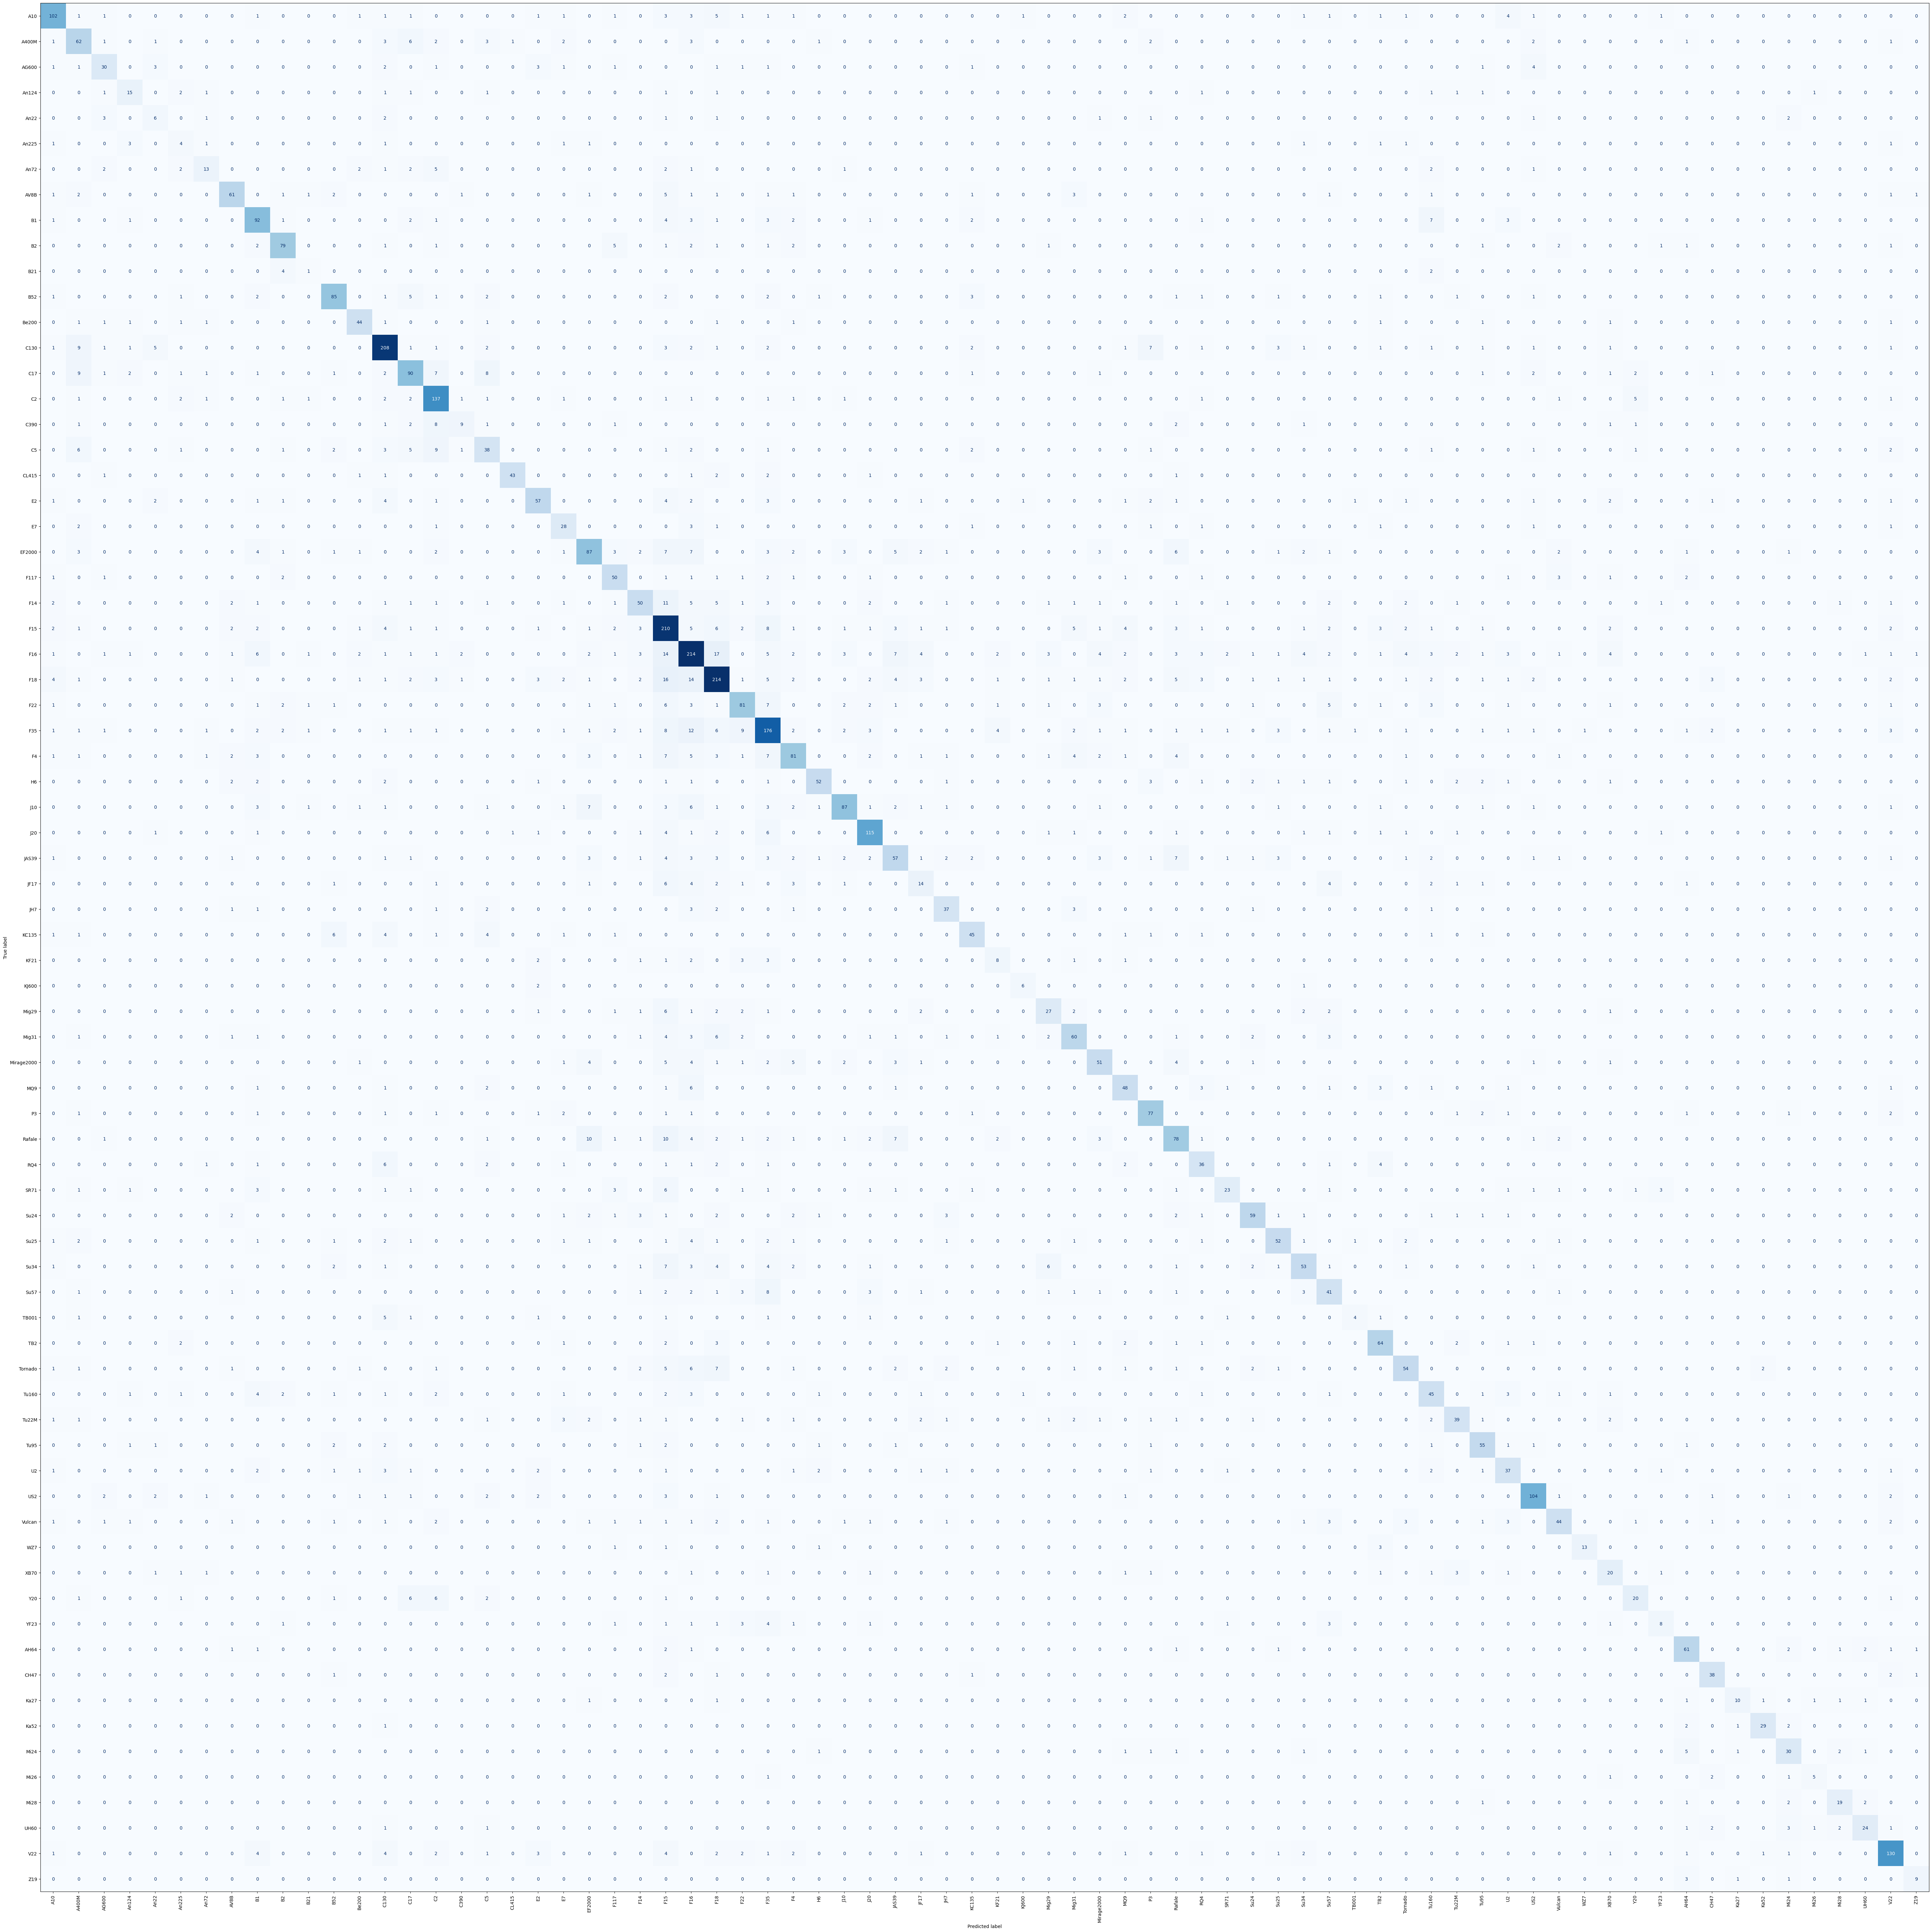

In [16]:
y_true, y_pred = metrics.model_predict(model, val_data)

fig, ax = plt.subplots(figsize=(classes_num, classes_num))
cmp = ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred, 
    display_labels=class_names, 
    cmap=plt.get_cmap('Blues'),
    colorbar=False, 
    xticks_rotation='vertical', 
    ax=ax
)